In [5]:
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import numpy as np
from datetime import datetime
from datetime import timedelta
import backtrader as bt
import pyfolio as pf
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

C:\Users\WIN10\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\ProgramDat

In [1]:
def load_data(ticker_ls, start_date, end_date):
    df = pd.DataFrame(columns = ticker_ls)
    
    for ticker in ticker_ls:
        df[ticker] = yf.download(ticker, start = start_date, end = end_date)["Adj Close"]
        
    return df

In [2]:
# 13612W filter: average annual returns over the past 1, 3, 6, 12 months.
def cal_momentum(df, ticker):
    p0 = df[ticker]
    
    # working days
    try:
        p1 = df[ticker].shift(20)
        p3 = df[ticker].shift(60)
        p6 = df[ticker].shift(120)
        p12 = df[ticker].shift(240)
        momentum = 12*(p0/p1-1) + 4*(p0/p3-1) + 2*(p0/p6-1) + 1*(p0/p12-1)
    
    except:
        pass
    
    return momentum

In [3]:
def select_asset(x):
    selected_df = pd.Series([0, 0], index=['selected', 'price'])
    
    # replace the assets in the Top T with non-positive momentum by the best cash-like asset
    if x['SPY_mom'] > 0 and x['EFA_mom'] > 0 and x['EEM_mom'] > 0 and x['AGG_mom'] > 0:
        selected_mom = max(x['SPY_mom'], x['EFA_mom'], x['EEM_mom'], x['AGG_mom'])
        
    else:
        selected_mom = max(x['SHY_mom'], x['IEF_mom'], x['LQD_mom'])
    
    # remove '_mom' from the seleceted asset name
    selected_df['selected'] = x[x==selected_mom].index[0][:3]
    selected_df['price'] = x[selected_df['selected']]
    
    return selected_df

In [6]:
start_date = datetime(2004, 1, 1)
end_date = datetime(2022, 12, 31)

risky_ls =  ['SPY', 'EFA', 'EEM', 'AGG']
cash_like_ls = ['SHY', 'IEF', 'LQD']

ticker_ls = risky_ls + cash_like_ls

df = load_data(ticker_ls, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
for ticker in ticker_ls:
    df[ticker+'_mom'] = 0
    df[ticker+'_mom'] = cal_momentum(df, ticker)

In [8]:
# need 12 lagged prices for the 13612W filter, so start one year after the start of the data.
df = df.loc[df.index >= '2005-01-01']

In [9]:
# Monthly rebalancing
df = df.resample(rule='M').last()

In [10]:
# select asset with highest momentum
df[['selected', 'price']] = df.apply(lambda x: select_asset(x), axis=1)

In [11]:
return_col = [ticker + '_return' for ticker in ticker_ls]
df[return_col] = df[ticker_ls].pct_change()

In [12]:
# Monthly return
df['return'] = 0
df['return_accum'] = 0

for i in range(len(df)):
    returns = 0
    
    if i > 0:
        returns = df[df.iloc[i-1]['selected'] + '_return'].iloc[i]
        
    df.loc[df.index[i], 'return'] = returns
    df.loc[df.index[i], 'return_accum'] = (1 + df.loc[df.index[i-1], 'return_accum'])*(1 + returns) - 1
    
df[['return', 'return_accum']] = df[['return', 'return_accum']]*100
df[return_col] = df[return_col] * 100

In [13]:
# Performance
CAGR = 100*(((1 + df['return_accum'][-1]/100)**(1/(len(df)/12))) - 1)
df['draw_down'] = 100 * ((1+df['return']/100).cumprod() - (1+df['return']/100).cumprod().cummax())/ (1+df['return']/100).cumprod().cummax()
MDD =  df['draw_down'].min()
RAD =  CAGR*(1-MDD/(1-MDD))*-1

In [14]:
df_performance = pd.Series({'CAGR' : round(CAGR,2), 'MDD' : round(MDD,2), 'RAD' : round(RAD,2)})
df_performance

CAGR    12.75
MDD    -14.30
RAD    -24.66
dtype: float64

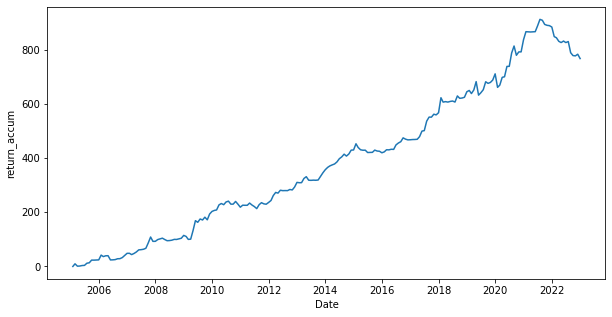

In [15]:
plt.figure(figsize=(10,5))
seaborn.lineplot(data=df, x=df.index, y=df['return_accum'])

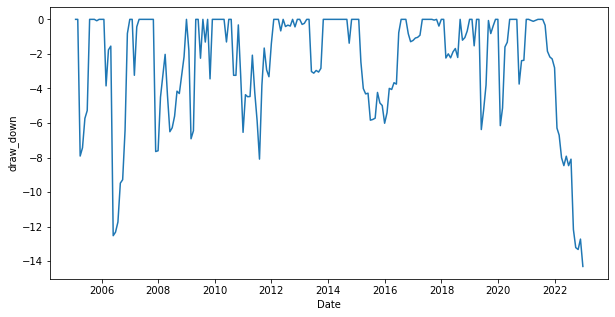

In [16]:
plt.figure(figsize=(10,5))
seaborn.lineplot(data=df, x=df.index, y=df['draw_down'])

In [17]:
# SPY return
df['SPY_return_accum'] = 0

for i in range(len(df)):
    if i > 0:
        df['SPY_return_accum'].iloc[i] = (1+ df['SPY_return_accum'].iloc[i-1])*(1 + (df['SPY_return'].iloc[i]/100))-1
df['SPY_return_accum'] = df['SPY_return_accum']*100

C:\Users\WIN10\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


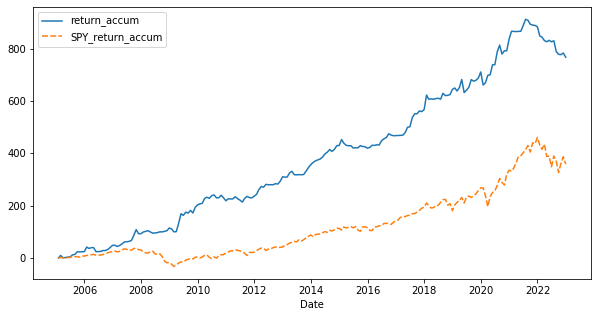

In [18]:
plt.figure(figsize=(10,5))
seaborn.lineplot(data=df[['return_accum','SPY_return_accum']])